# 02 - Zeisel NIMFA

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from numpy import ma
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE
from umap import UMAP

from sklearn.preprocessing import StandardScaler

import nimfa as ni
import scipy as sp

In [2]:
sp.__version__, np.__version__, pd.__version__

('1.1.0', '1.11.3', '0.23.1')

In [3]:
zeisel_path = '/media/tmo/data/work/datasets/zeisel/expression_sara_filtered.txt'
zeisel_meta_path = '/media/tmo/data/work/datasets/zeisel/expression_mRNA_17-Aug-2014.txt'

In [4]:
%%time
zeisel_df = pd.read_csv(zeisel_path, sep='\t', skiprows=1, header=None, index_col=0)
zeisel_df.index.name = 'gene'

CPU times: user 4.78 s, sys: 370 ms, total: 5.15 s
Wall time: 5.15 s


In [5]:
zeisel_meta_df = pd.read_table(zeisel_meta_path, nrows=12, index_col=1, header=None)
zeisel_meta_df.drop(zeisel_meta_df.columns[0], axis=1, inplace=True)
zeisel_meta_df = zeisel_meta_df.T.reset_index()[['tissue', 'level1class', 'level2class']]
zeisel_meta_df.index.name = 'cell'

In [6]:
for meta_col in zeisel_meta_df.columns:
    zeisel_meta_df[meta_col] = zeisel_meta_df[meta_col].astype('category')

In [7]:
zeisel_meta_df.head()

1,tissue,level1class,level2class
cell,,,
0,sscortex,interneurons,Int10
1,sscortex,interneurons,Int10
2,sscortex,interneurons,Int6
3,sscortex,interneurons,Int10
4,sscortex,interneurons,Int9


In [113]:
pd.DataFrame(zeisel_df.mean(axis=1)).sort_values(by=0, ascending=False)[:10]

,0
gene,
Malat1,732.152413
Plp1,164.499501
Calm1,78.306822
Calm2,62.941431
Meg3,54.931115
Ppia,51.419967
Tmsb4x,49.425624
Hsp90ab1,48.355408
Hsp90aa1,47.970050


In [91]:
genes = zeisel_df.index

In [13]:
zeisel_m = zeisel_df.values

In [14]:
zeisel_m.shape

(13063, 3005)

In [115]:
scaler = StandardScaler(with_mean=False, with_std=True)

In [134]:
zeisel_m_std = scaler.fit_transform(zeisel_df.T.reset_index(drop=True)).T

In [135]:
zeisel_m_std.shape

(13063, 3005)

---

# SPA selection 

In [12]:
%%time
sep_spa_fit = ni.SepNmf(zeisel_m)()

CPU times: user 32min 19s, sys: 7min 35s, total: 39min 55s
Wall time: 3min 44s


In [14]:
sep_spa_W = sep_spa_fit.basis()

In [15]:
sep_spa_H = sep_spa_fit.coef()

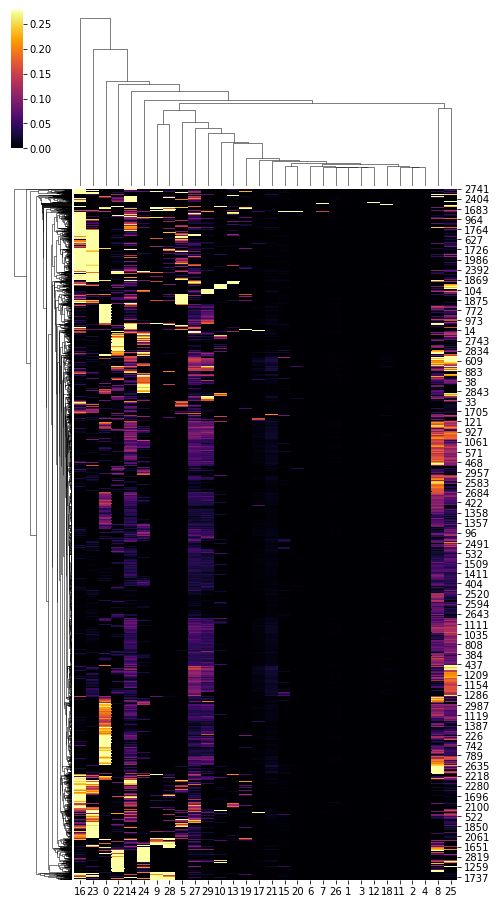

In [18]:
sns.clustermap(sep_spa_H.T,
               cmap='inferno',               
               robust=True, 
               figsize=(8, 16))
plt.show()

In [19]:
%%time
sep_spa_umap_df = pd.DataFrame(UMAP(random_state=666).fit_transform(sep_spa_H.T))

CPU times: user 23.2 s, sys: 10.1 s, total: 33.4 s
Wall time: 20.7 s


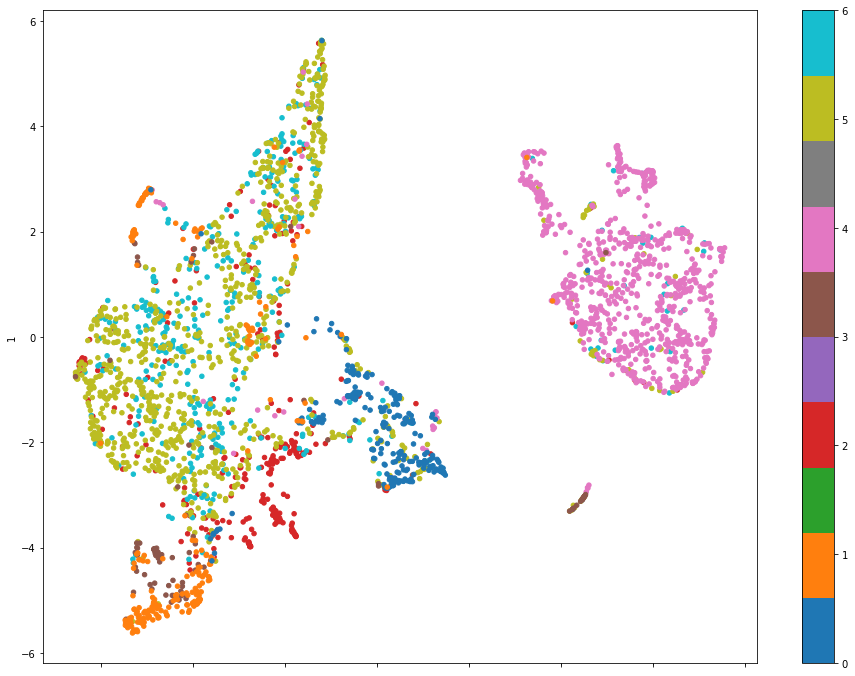

In [20]:
sep_spa_umap_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

---

# SPA - structured compression

* more components required than when using sparse NMF.
* 

In [16]:
%%time
sep_spa_struct_fit = ni.SepNmf(zeisel_m, compression='structured', selection='spa', rank=50, seed=777)()

CPU times: user 2 s, sys: 1.66 s, total: 3.66 s
Wall time: 1.74 s


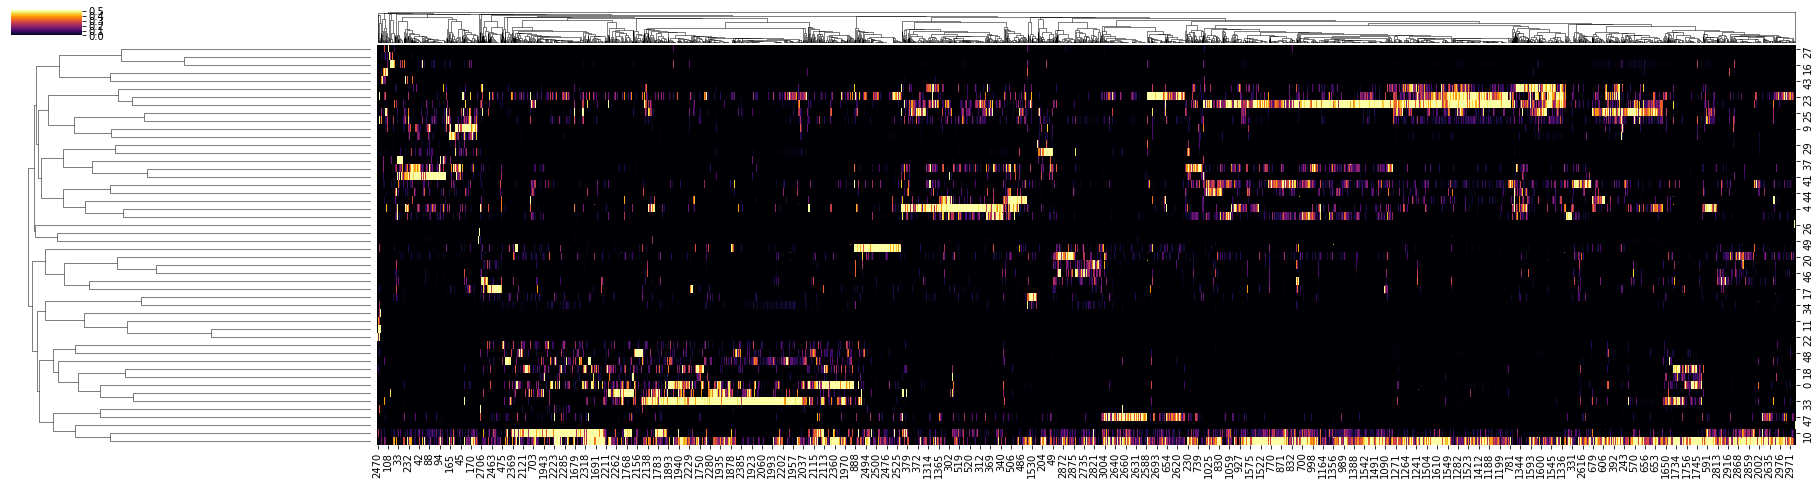

In [17]:
sns.clustermap(sep_spa_struct_fit.coef(),
               cmap='inferno',
               metric='correlation',
               robust=True, 
               figsize=(32, 8))
plt.show()

In [42]:
W = np.asarray(sep_spa_struct_fit.basis().T)

Init signature: filter(self, /, *args, **kwargs)
Docstring:     
filter(function or None, iterable) --> filter object

Return an iterator yielding those items of iterable for which function(item)
is true. If function is None, return the items that are true.
Type:           type


In [73]:
def calculate_meta_genes(W, genes):
    n_meta_genes = W.shape[0]
    
    meta_genes = []
    for i in range(n_meta_genes):
        w = pd.DataFrame(list(zip(list(W[i]), genes)), columns=['weight', 'gene'])
        w = w[w.weight > 0].sort_values(by='weight', ascending=False)
        meta_genes.append(w)
        
    return meta_genes

In [74]:
meta_genes = calculate_meta_genes(W, genes)

In [78]:
meta_genes[0][:25]

,weight,gene
3250,1106.0,Malat1
3148,262.0,Plp1
3494,141.0,Trf
3423,87.0,Mal
1791,37.0,Fth1
3263,34.0,Enpp2
1759,34.0,Gstp1
3445,33.0,Car2
3247,27.0,Mog
1581,25.0,Ywhaq


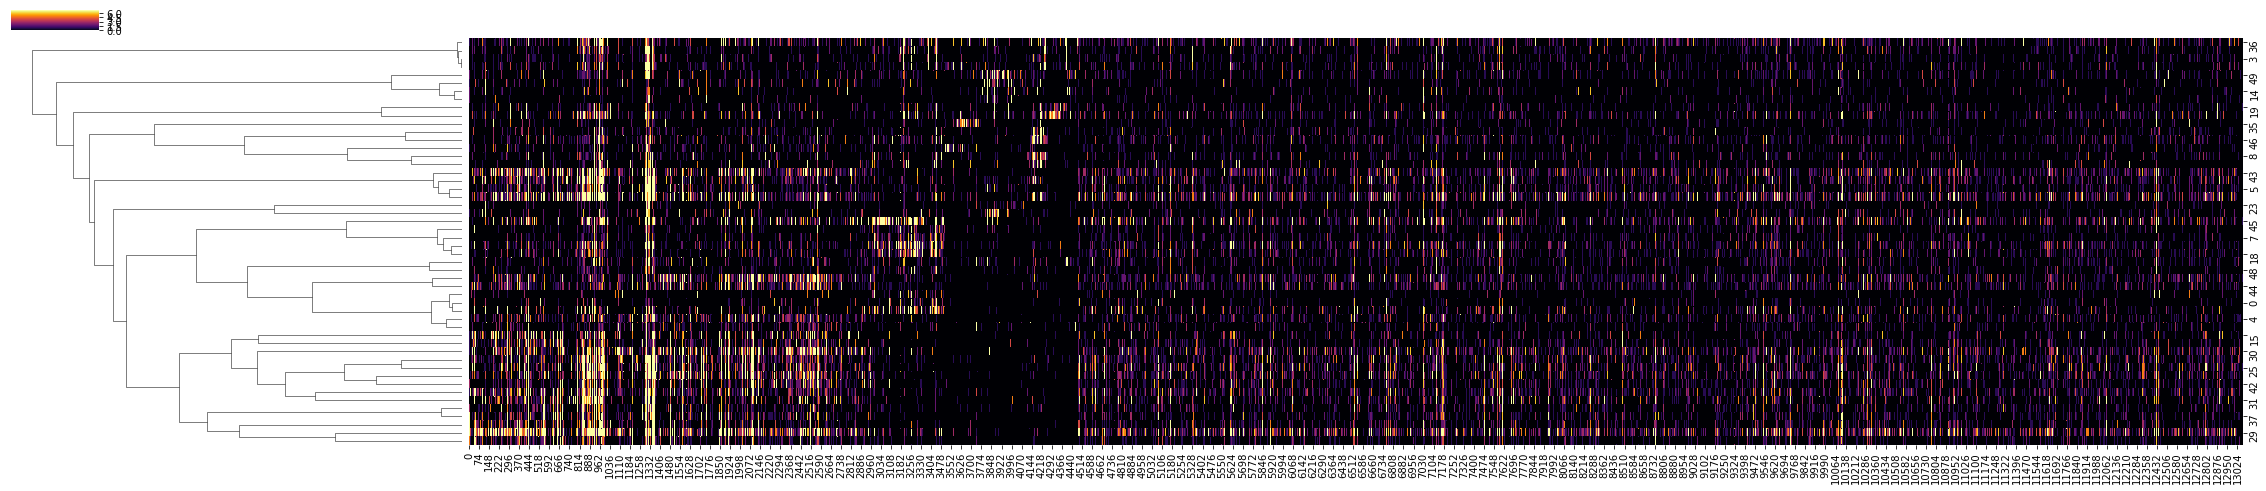

In [29]:
sns.clustermap(sep_spa_struct_fit.basis().T,
               cmap='inferno',
               col_cluster=False,
               metric='correlation',
               robust=True, 
               figsize=(40, 8))
plt.show()

In [23]:
%%time
sep_spa_struct_umap_df = pd.DataFrame(UMAP(random_state=666).fit_transform(sep_spa_struct_fit.coef().T))

CPU times: user 23.4 s, sys: 11 s, total: 34.4 s
Wall time: 20.9 s


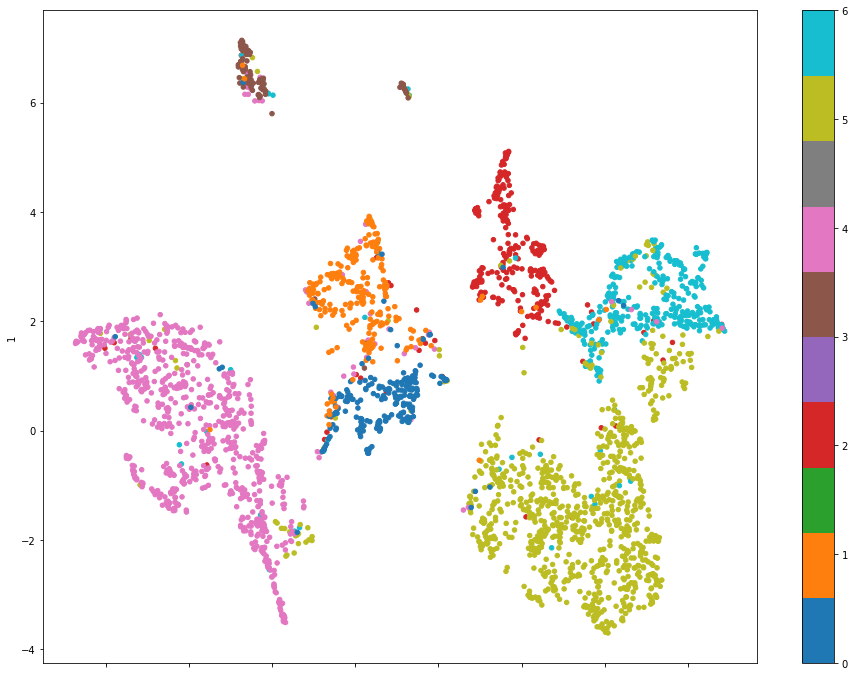

In [24]:
sep_spa_struct_umap_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

In [150]:
%%time
sep_spa_struct_tsne_df = pd.DataFrame(TSNE(random_state=666).fit_transform(sep_spa_struct_fit.coef().T))

CPU times: user 1min 5s, sys: 35 s, total: 1min 40s
Wall time: 1min 40s


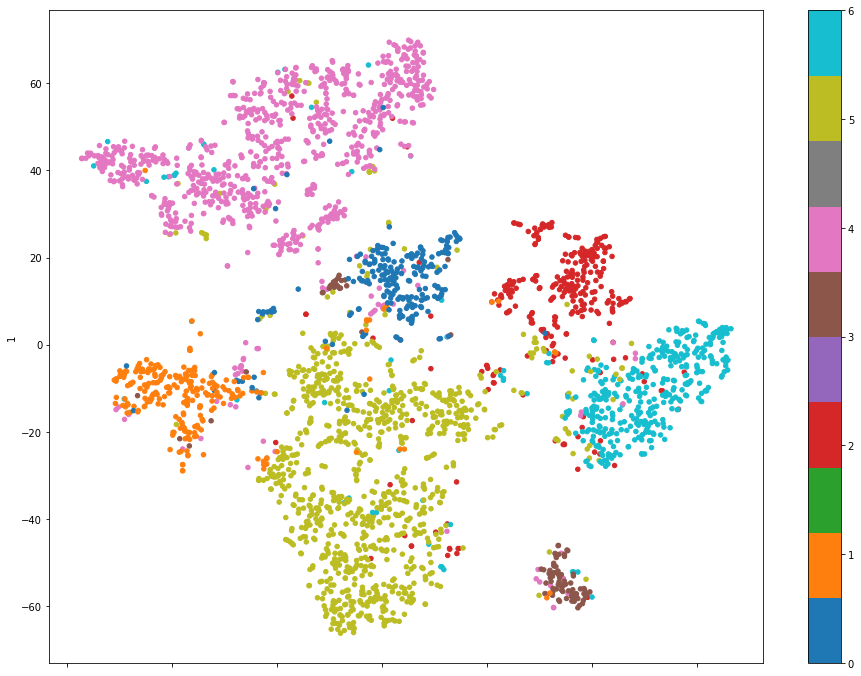

In [151]:
sep_spa_struct_tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

---

# SPA - QR compression
* urgh, looks bad

In [111]:
%%time
sep_spa_qr_fit = ni.SepNmf(zeisel_m, compression='qr', selection='spa', rank=30, seed=777)()

CPU times: user 5min 39s, sys: 8min 35s, total: 14min 14s
Wall time: 37.3 s


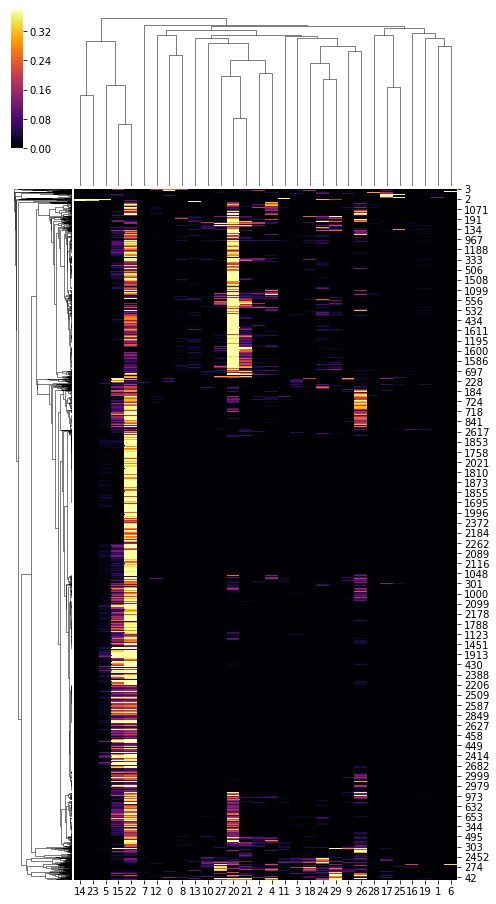

In [130]:
sns.clustermap(sep_spa_qr_fit.coef().T,
               cmap='inferno',   
               robust=True, 
               metric='correlation',
               figsize=(8, 16))
plt.show()

In [113]:
%%time
sep_spa_qr_umap_df = pd.DataFrame(UMAP(random_state=666).fit_transform(sep_spa_qr_fit.coef().T))

CPU times: user 14.5 s, sys: 10.8 s, total: 25.3 s
Wall time: 12 s


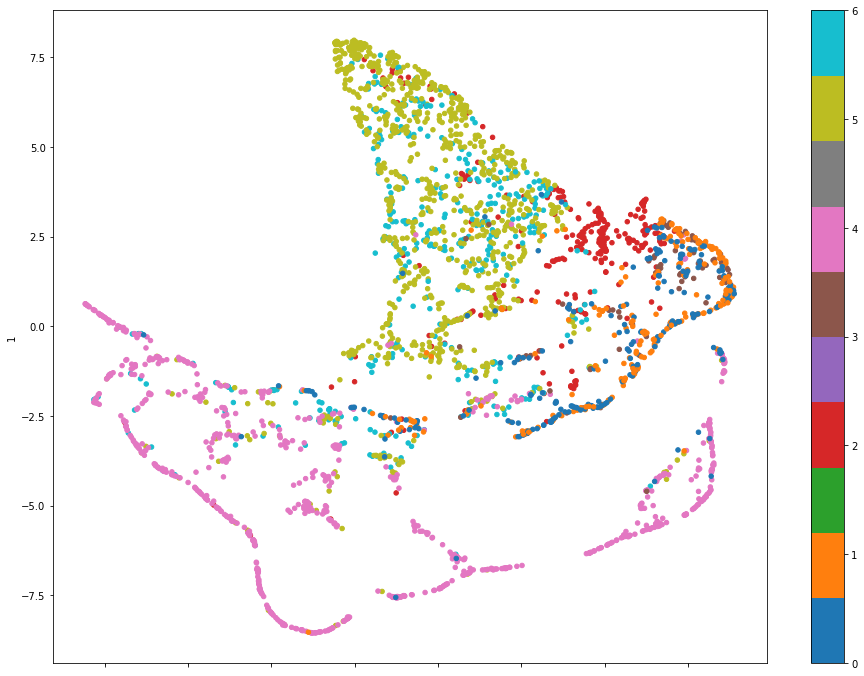

In [114]:
sep_spa_qr_umap_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()

In [115]:
%%time
sep_spa_qr_tsne_df = pd.DataFrame(TSNE(random_state=666).fit_transform(sep_spa_qr_fit.coef().T))

CPU times: user 59.2 s, sys: 35.5 s, total: 1min 34s
Wall time: 1min 34s


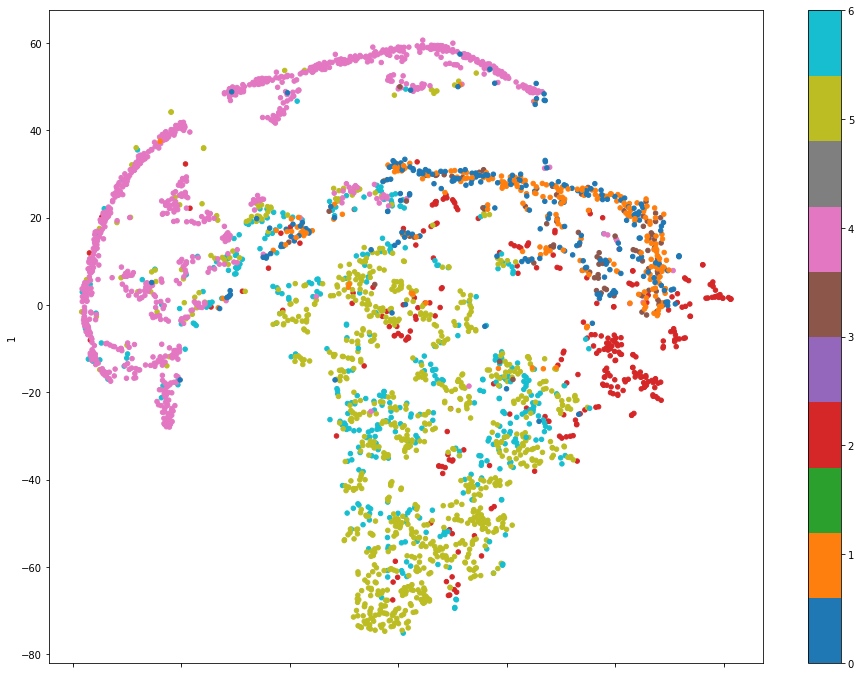

In [116]:
sep_spa_qr_tsne_df.plot.scatter(x=0, y=1, c=zeisel_meta_df['level1class'].cat.codes, cmap=plt.cm.get_cmap('tab10'), figsize=(16,12))
plt.show()